In [14]:
!pip install git+https://github.com/benjs/nfnets_pytorch torchvision>=0.8

  Running command git clone --filter=blob:none --quiet https://github.com/benjs/nfnets_pytorch /tmp/pip-req-build-1cx_g9lh


In [15]:
import PIL
import requests
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
from nfnets import pretrained_nfnet
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

In [16]:
!mkdir -p pretrained
!wget https://storage.googleapis.com/dm-nfnets/F0_haiku.npz -N -P pretrained

--2025-04-15 08:10:14--  https://storage.googleapis.com/dm-nfnets/F0_haiku.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘pretrained/F0_haiku.npz’ not modified on server. Omitting download.



In [17]:
r = requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")

classes = []
for line in r.iter_lines():
    classes.append(str(line).split("'")[1])

In [18]:
model = pretrained_nfnet('pretrained/F0_haiku.npz')

In [19]:
transforms = Compose([
    ToTensor(),
    Resize((model.test_imsize + 32, model.test_imsize + 32), PIL.Image.BICUBIC),
    CenterCrop((model.test_imsize, model.test_imsize)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
import io
def load_img(url:str):
    #img = Image.open(io.BytesIO(requests.get(url, stream=True).content))
    img = Image.open(url)
    tensor = transforms(img)[None, :, :]
    return img, tensor

In [28]:
def eval(input:torch.Tensor):
    model.eval()
    with torch.no_grad():
        output = F.softmax(model(input), dim=1)

    vals, preds = torch.topk(output, 5 , 1)

    for val, pred in iter(zip(vals[0], preds[0])):
        print(f"{val*100.0:4.2f}%: {classes[pred.item()]}")

In [44]:
urls = [
    "/content/1.png",
]

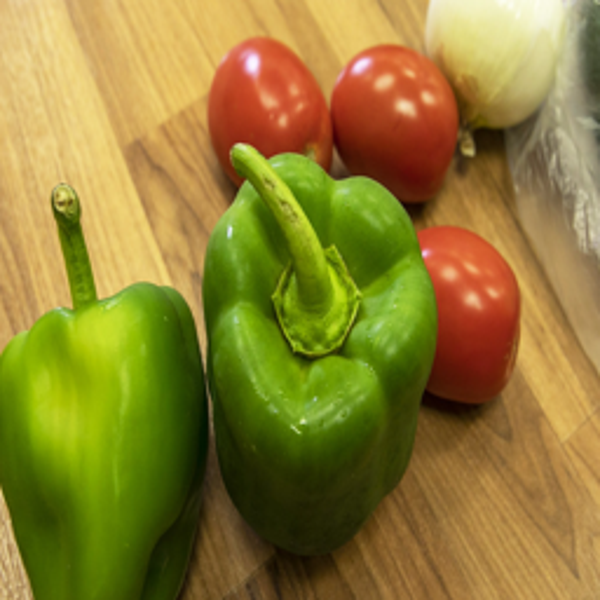

38.35%: bell pepper
0.56%: grocery store, grocery, food market, market
0.30%: cucumber, cuke
0.26%: Granny Smith
0.21%: mortar


In [47]:
for url in urls:
    img, tensor = load_img(url)

    display(img.resize((int(x*600/max(img.size)) for x in img.size)))
    eval(tensor)